<font size="6.2">Summary</font>

This notebook demonstrates how to containerize a simple machine learning application, covering the full workflow from model training to deployment. The key steps include:

1. **Train a Machine Learning Model**
   * Load and preprocess data, then train an XGBoost model using scikit-learn.
   * Save the trained model as a `.pkl` file for later deployment.

2. **Manual Containerization**

   * Copy the source code into a container and run the application inside it.
   * Convert the running container into a Docker image using `docker container commit`.

3. **Containerization via Dockerfile**

   * Create a Dockerfile specifying the runtime, dependencies, and startup command.
   * Build a Docker image locally using `docker build`.

4. **Push Docker Image to Docker Hub**

   * Log in to Docker Hub, tag the image, and push it to your repository.
   * Verify that the image is available in your Docker Hub account.

5. **Deploy on Hugging Face Spaces (Free Tier)**

   * Create a new Hugging Face Space with Docker as the runtime.
   * Connect to GitHub or upload the Dockerfile and model files.
   * Configure the Space to pull your Docker image from Docker Hub.
   * Launch and test the web-based app in a fully hosted environment.

Python functions and data files needed to run this notebook are available via this repo [containerizing_ml_model_with_docker](https://github.com/MehdiRezvandehy/containerizing_ml_model_with_docker.git).

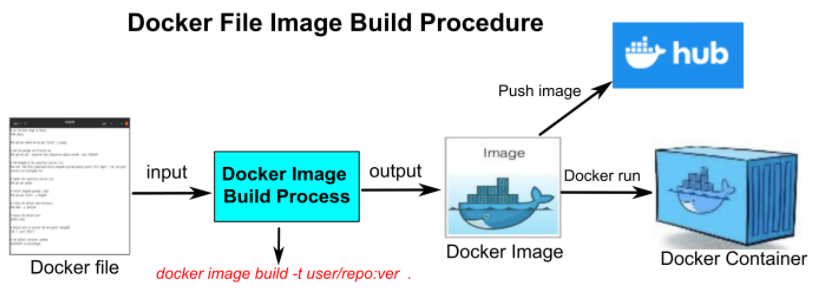


#  Train a Simple ML Model

The code below trains a simple XGBoost model using the PaySim dataset from Kaggle ([https://www.kaggle.com/datasets/ealaxi/paysim1](https://www.kaggle.com/datasets/ealaxi/paysim1)). PaySim simulates mobile money transactions based on a one-month sample of real financial logs from a mobile money service in an African country.

The code is implemented as a Python script (`train_model.py`). When executed, it trains the XGBoost model and generates pickle files for both data preprocessing and the trained model.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# -----------------------------
# 1. Load dataset
# -----------------------------
# You can get the dataset from: https://www.kaggle.com/datasets/ealaxi/paysim1
# File name: PS_20174392719_1491204439457_log.csv
print("📥 Loading dataset (PaySim synthetic transaction data)...")
df = pd.read_csv("data/PS_20174392719_1491204439457_log.csv")

# -----------------------------
# 2. Keep relevant columns
# -----------------------------
cols = [
    'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest', 'isFraud'
]
df = df[cols]

# -----------------------------
# 3. Encode and clean
# -----------------------------
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])  # e.g., TRANSFER, CASH_OUT, PAYMENT, etc.

# Replace NaN and inf
df = df.replace([float('inf'), float('-inf')], 0).fillna(0)

# -----------------------------
# 4. Split features/target
# -----------------------------
X = df.drop('isFraud', axis=1)
y = df['isFraud']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 5. Train model
# -----------------------------
print("🧠 Training XGBoost model...")
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

# -----------------------------
# 6. Evaluate
# -----------------------------
y_pred = model.predict(X_test)
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

# -----------------------------
# 7. Save model and scaler
# -----------------------------
with open("./pickles/fraud_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("./pickles/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("./pickles/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("\n✅ Model, scaler, and encoder saved successfully!")


📥 Loading dataset (PaySim synthetic transaction data)...
🧠 Training XGBoost model...

📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85492
           1       0.12      0.84      0.21        44

    accuracy                           1.00     85536
   macro avg       0.56      0.92      0.61     85536
weighted avg       1.00      1.00      1.00     85536


✅ Model, scaler, and encoder saved successfully!


# Streamlit App

The code below is a Streamlit application that loads the pickle files generated by the model training script (`train_model.py`). It is implemented as a Python script (`app.py`).

In [ ]:
import streamlit as st
import pandas as pd
import pickle
import numpy as np

# -----------------------------
# 1. Load Model and Preprocessors
# -----------------------------
@st.cache_resource
def load_artifacts():
    model = pickle.load(open("./pickles/fraud_model.pkl", "rb"))
    scaler = pickle.load(open("./pickles/scaler.pkl", "rb"))
    le = pickle.load(open("./pickles/label_encoder.pkl", "rb"))
    return model, scaler, le

model, scaler, le = load_artifacts()

# -----------------------------
# 2. Streamlit App UI
# -----------------------------
st.set_page_config(page_title="Realistic Fraud Detection App", layout="centered")

st.title("💳 Transaction Fraud Detection")
st.write("Model trained on the **PaySim synthetic transaction dataset** — features mimic real financial data.")

# Input fields
st.subheader("Enter Transaction Details")

transaction_type = st.selectbox(
    "Transaction Type",
    le.classes_.tolist()
)
amount = st.number_input("💰 Transaction Amount ($)", 0.0, 100000.0, 2500.0, step=100.0)
oldbalanceOrg = st.number_input("🏦 Sender’s Old Balance", 0.0, 1000000.0, 5000.0, step=100.0)
newbalanceOrig = st.number_input("🏦 Sender’s New Balance", 0.0, 1000000.0, 2500.0, step=100.0)
oldbalanceDest = st.number_input("💼 Receiver’s Old Balance", 0.0, 1000000.0, 10000.0, step=100.0)
newbalanceDest = st.number_input("💼 Receiver’s New Balance", 0.0, 1000000.0, 12500.0, step=100.0)

# Convert to model input
type_encoded = le.transform([transaction_type])[0]
input_df = pd.DataFrame([{
    'type': type_encoded,
    'amount': amount,
    'oldbalanceOrg': oldbalanceOrg,
    'newbalanceOrig': newbalanceOrig,
    'oldbalanceDest': oldbalanceDest,
    'newbalanceDest': newbalanceDest
}])

# -----------------------------
# 3. Prediction Trigger Button
# -----------------------------
if st.button("🔍 Predict Fraud"):
    # Scale input
    input_scaled = scaler.transform(input_df)
    prob = model.predict_proba(input_scaled)[0][1]
    pred = model.predict(input_scaled)[0]

    st.write("---")
    st.subheader("🔍 Prediction Result")
    if pred == 1:
        st.error(f"⚠️ Fraudulent Transaction Detected! (Probability: {prob:.2f})")
    else:
        st.success(f"✅ Legitimate Transaction (Probability of Fraud: {prob:.2f})")

else:
    st.info("🧭 Fill out the form above and click **'🔍 Predict Fraud'** to see results.")

st.caption("This demo uses the PaySim synthetic dataset (simulating mobile money transactions).")


# Build Container Image 

## Manual Procedure

It’s generally recommended to use a **Dockerfile** to build an image, but before doing so, we’ll first go through the **manual container build process** to understand each step involved. A Dockerfile essentially translates this manual procedure into **code**, allowing us to **automate and reproduce** the process easily. If we skip straight to automation, we lose the opportunity to understand what’s actually happening behind the scenes — how a container is built, configured, and run.

To begin, we will:

1. **Clone** the application code from the GitHub repository to the local development machine.
2. **Create a containerized development environment** using a **pre-built Maven image**, which already includes the necessary build tools.
3. **Copy** the application’s source code into the container.
4. **Connect** to the running container and perform all the steps required to build the application inside it.
5. **Run and test** the application within the container to verify that it works as expected.
6. Once everything is working correctly, **commit the container’s state** to a new image using the `docker container commit` command.

After this manual setup (see schematic illustration below), we can use a **Dockerfile** to capture the same steps in code, making the build process **repeatable, consistent, and automated**.


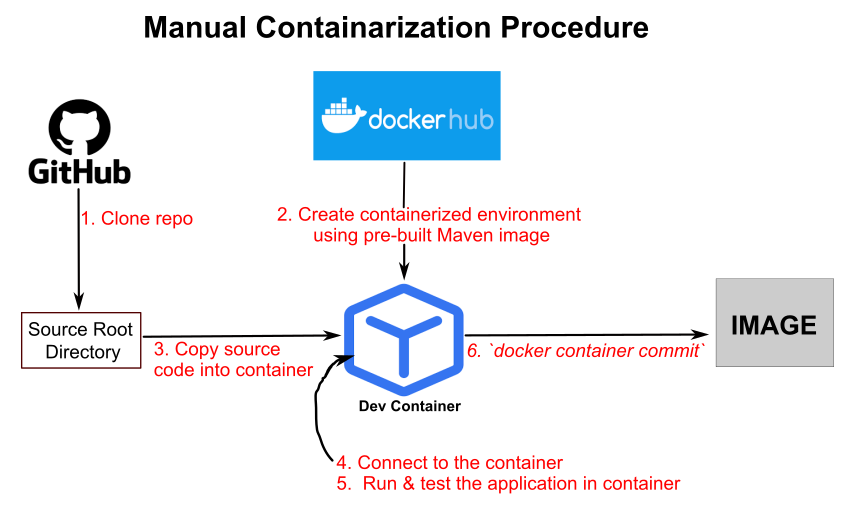

### Clone Repo with Codes and Dependencies

The code repository that contains codes for fraud detection model are in  https://github.com/MehdiRezvandehy/contrizing_ml_model_with_docker.git. The pickle files should be available in repo since we are not creating again in container.

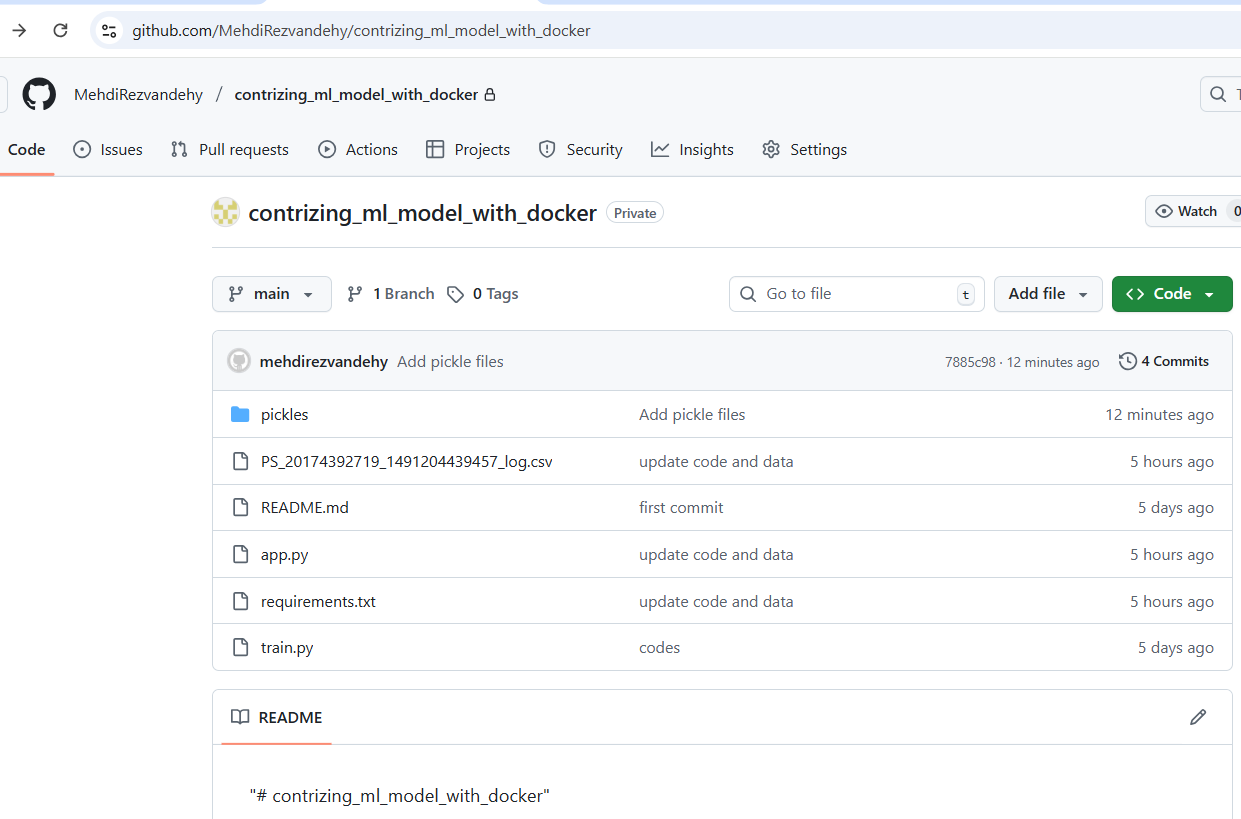

### Create Containerized Environment 

We want to get an image from DockerHub that python has been installed
  
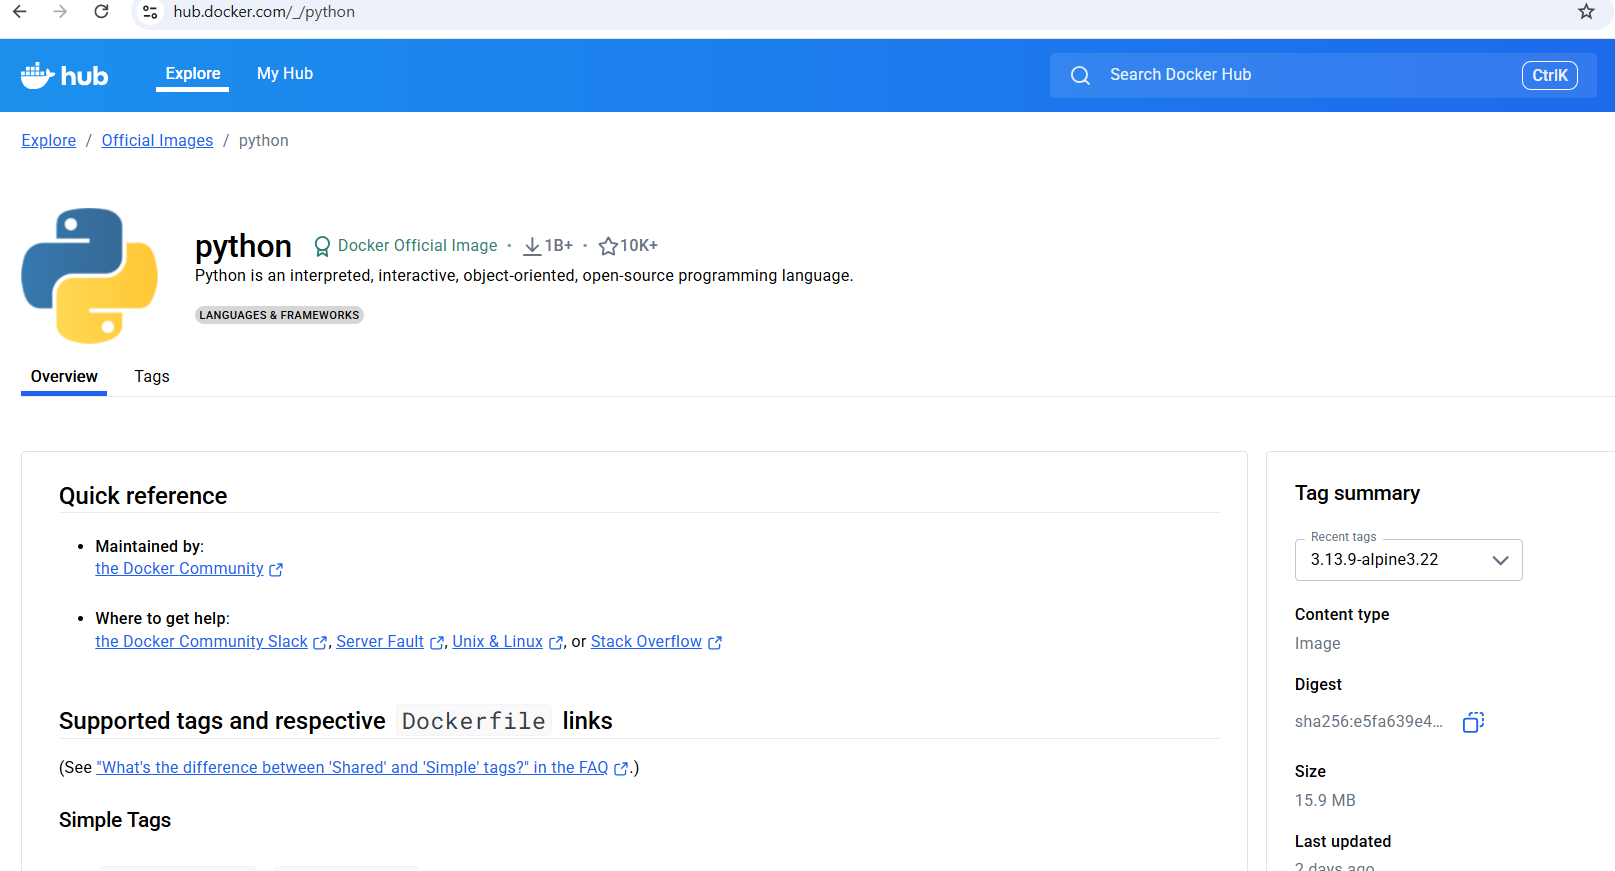

The latest version of Python 3.11 (3.11.12-slim) is used:

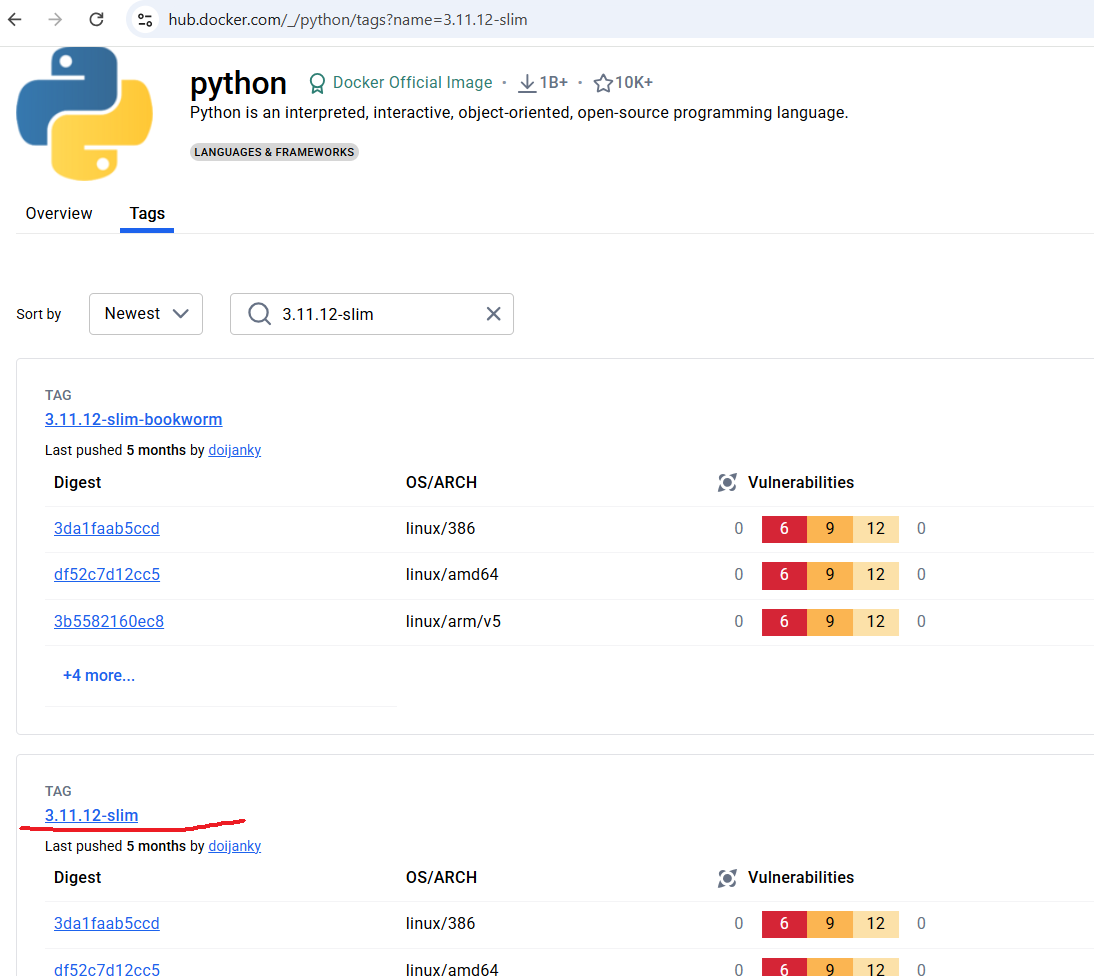

Run a dev container with `python: 3.11.12-slim` image to test build the image with `docker run -idt -p 8501:8501 --name dev_fraud_container python:3.11.12-slim `: -idt to make sure this container comes up and keeps running in background, -p is for port mapping as below:

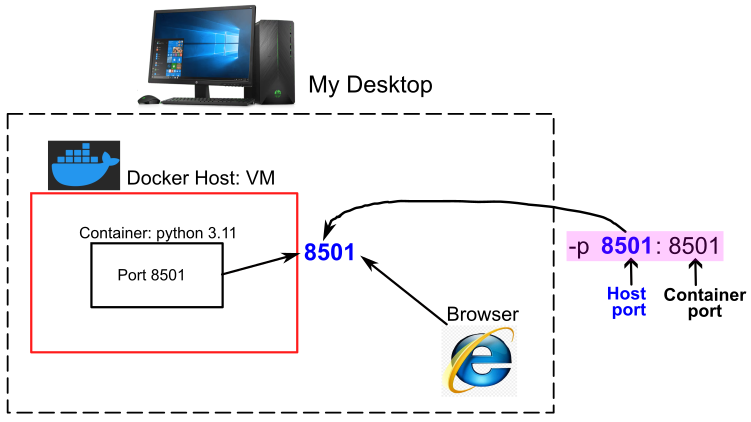

In [3]:
!docker run -idt -p 8501:8501 --name dev_fraud_container python:3.11.12-slim

67cbd3737e3fa0a45c4c414bba61f4ffbb83fb357086a9f7b533f45909d29bd9


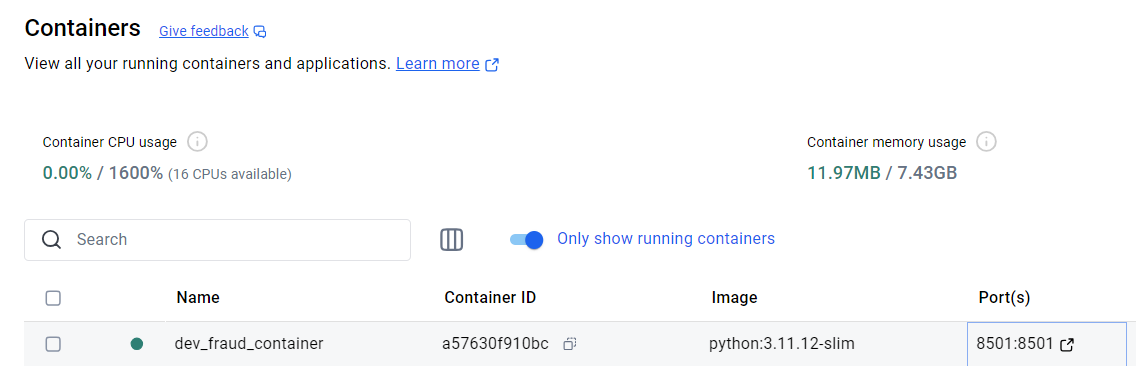

In [4]:
!docker ps

CONTAINER ID   IMAGE                 COMMAND     CREATED                  STATUS                  PORTS                    NAMES
67cbd3737e3f   python:3.11.12-slim   "python3"   Less than a second ago   Up Less than a second   0.0.0.0:8501->8501/tcp   dev_fraud_container


The container has been created, now we can use to build the application within in. Then name of application is **dev_fraud_container**. The mapping from host side "0.0.0.0:5001" to container "5000", the image is `python:3.11.12-slim` that runs with "python3".

### Copy the Source Code to Container

Use this code `docker cp . dev_fraud_container:/app` to copy (`cp`) everything in current path (that is the `.`) into `/app`.

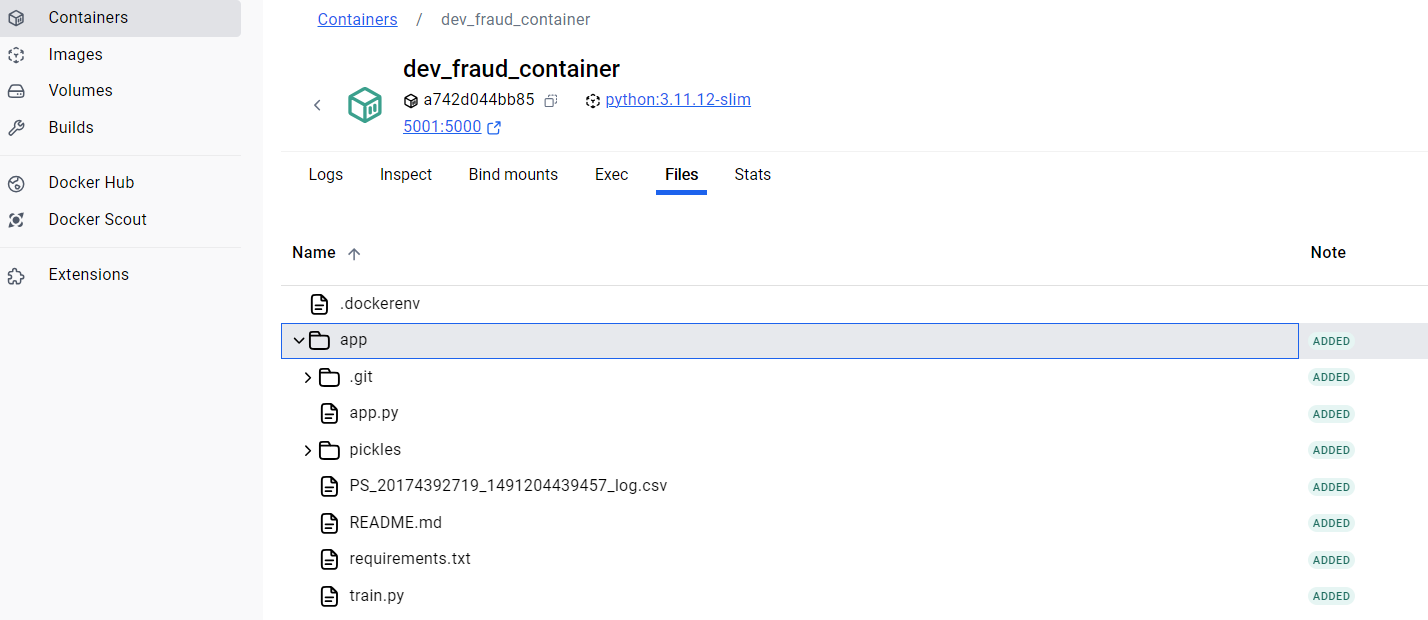

In [5]:
!docker cp . dev_fraud_container:/app

### Go Inside the Application

To go inside container, `docker exec -it dev_fraud_container bash` command using id or name should be applied. Then go to the app folder:
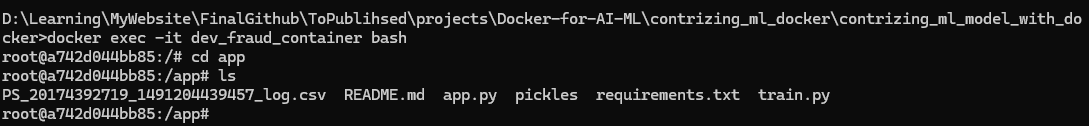

Now we are inside the container.

Next, we need to install dependencies inside container using `pip install -r requirements.txt` 
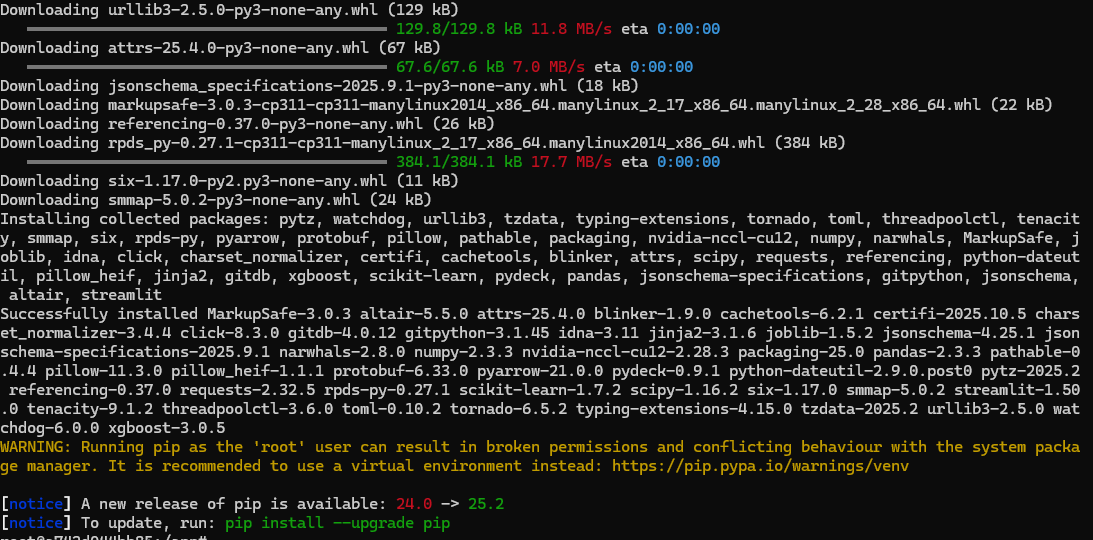

### Run App inside Container

After installing all dependencies, we can run streamlit app inside the container by `streamlit run app.py`
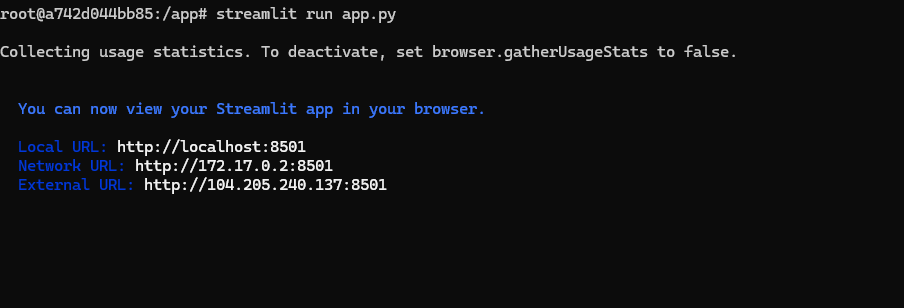

We can see the app on http://localhost:8501/ run inside the container. This means the container has everything to run the app within it.

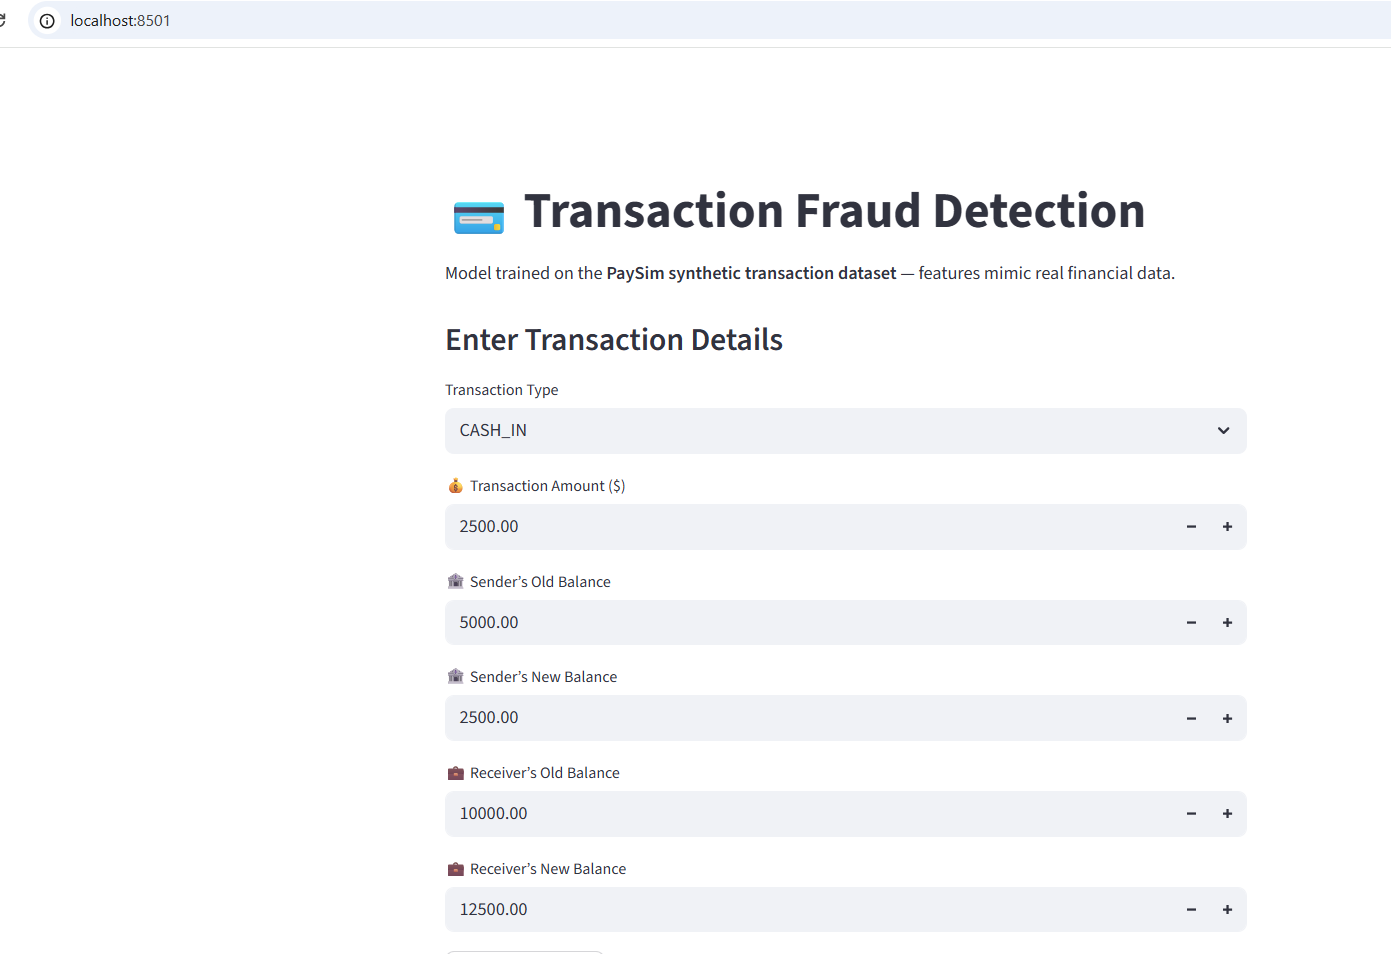

### Convert the Container to Image 

The final step is to **create a Docker image from the running container**.

First, exit the container properly:

1. Stop the app using `Ctrl + c` if it is still running.
2. Exit the container using `exit` or `Ctrl + d`.

Next, we can build an image from the container using the `docker container commit` command. It’s a good practice to include  Docker Hub username in the image name so that it can later be pushed to your Docker Hub account using the same ID.

Example command:

`docker container commit dev_fraud_container docker.io/mrezvandehy/contrizing_ml_model_with_docker:v1`


Here is description for the command:

* `mrezvandehy` is Docker Hub username.
* `contrizing_ml_model_with_docker` is the image (and also matches your GitHub repository name).
* `v1` represents version 1 of the image.

The full image name `docker.io/mrezvandehy/contrizing_ml_model_with_docker:v1` uniquely identifies your image in Docker Hub.


In [6]:
!docker container commit dev_fraud_container docker.io/mrezvandehy/contrizing_ml_model_with_docker:v1

sha256:8b354c628b4c000432112a7990acfa320abbdd49d878c0e51091a8e0e45b908a


Now we can list the images:

In [7]:
!docker image ls

REPOSITORY                                    TAG            IMAGE ID       CREATED             SIZE
mrezvandehy/contrizing_ml_model_with_docker   v1             8b354c628b4c   1 second ago        294MB
<none>                                        <none>         2fcf0c708a13   5 minutes ago       369MB
<none>                                        <none>         a15bd71a2cd7   About an hour ago   3.35GB
python                                        3.11.12-slim   dbf1de478a55   7 months ago        195MB


We can push the image into registry now. First use `docker login`:

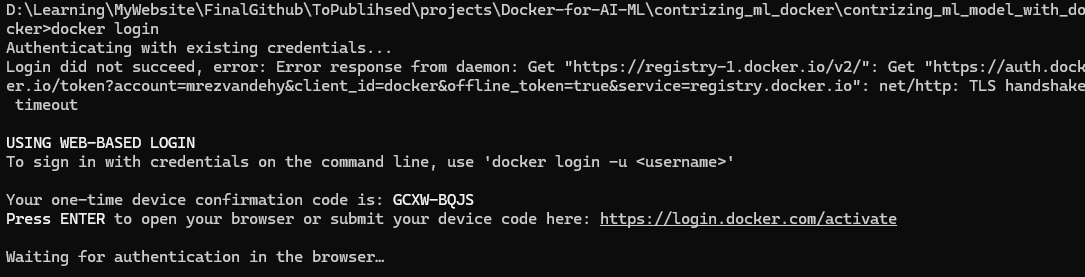

Now push the image into registry using `docker image push docker.io/mrezvandehy/contrizing_ml_model_with_docker:v1`. This may take some time depending the size of image:

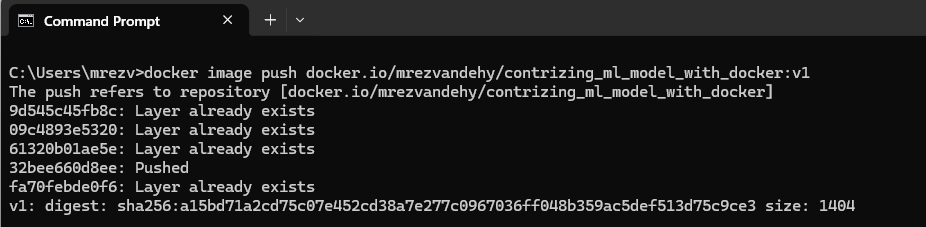

In [8]:
!docker image push docker.io/mrezvandehy/contrizing_ml_model_with_docker:v1

The push refers to repository [docker.io/mrezvandehy/contrizing_ml_model_with_docker]
9d545c45fb8c: Waiting
09c4893e5320: Waiting
9121df072490: Waiting
fa70febde0f6: Waiting
61320b01ae5e: Waiting
9121df072490: Waiting
fa70febde0f6: Waiting
61320b01ae5e: Waiting
9d545c45fb8c: Waiting
09c4893e5320: Waiting
9d545c45fb8c: Waiting
09c4893e5320: Waiting
9121df072490: Waiting
fa70febde0f6: Waiting
61320b01ae5e: Waiting
9121df072490: Waiting
fa70febde0f6: Waiting
61320b01ae5e: Waiting
9d545c45fb8c: Waiting
09c4893e5320: Waiting
09c4893e5320: Waiting
9121df072490: Waiting
fa70febde0f6: Waiting
61320b01ae5e: Waiting
9d545c45fb8c: Waiting
9121df072490: Waiting
fa70febde0f6: Waiting
61320b01ae5e: Layer already exists
9d545c45fb8c: Layer already exists
09c4893e5320: Waiting
fa70febde0f6: Layer already exists
09c4893e5320: Layer already exists
9121df072490: Waiting
9121df072490: Pushed
v1: digest: sha256:8b354c628b4c000432112a7990acfa320abbdd49d878c0e51091a8e0e45b908a size: 1402


The image has been published to the registry, we can see it on registry. Go to your profile, you can see your image as below https://hub.docker.com/repository/docker/mrezvandehy/contrizing_ml_model_with_docker/tags:

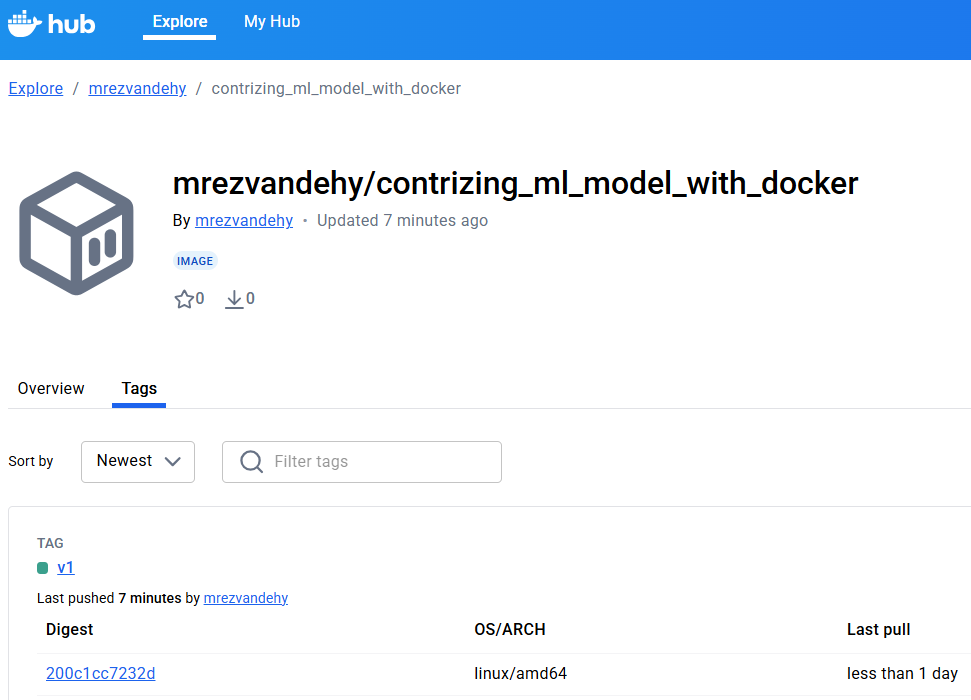

## Using Docker File

As we saw in the previous section, the manual approach to building a Docker image involves several steps. Now that we understand the process, we can convert it into code using a **Dockerfile**.

The idea is simple: we take the manual steps and write them as instructions in a Dockerfile. Then, we use the Docker build command to automatically generate the image:

```bash
docker image build -t user/repo:version .
```

This command builds the image from the Dockerfile and tags it with a name and version (for example, `mrezvandehy/contrizing_ml_model_with_docker:v1`). Once the image is successfully built, it’s ready to be **pushed to a container registry** or used directly to **launch containers** with the `docker run` command. See the schematic below:

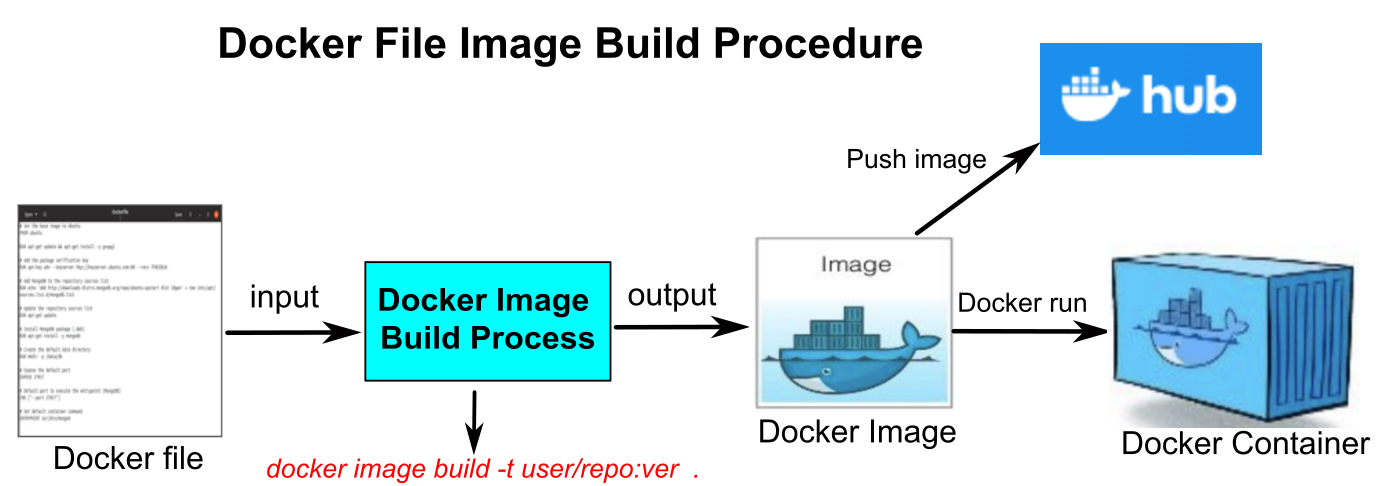

### Create Dockerfile

A **Dockerfile** is a text-based configuration file that defines how to build a Docker image. It allows you to **create images programmatically** and easily **share them** across environments.

Each line in a Dockerfile is an **instruction**, typically written in **uppercase** (e.g., `FROM`, `COPY`, `RUN`, `EXPOSE`) to distinguish it from its arguments.

A Dockerfile usually begins with a `FROM` instruction, which specifies the **base image** — the starting point for your environment. This base image can be any operating system or a pre-configured environment such as `python:3.11-slim`.

Next, you can define a **working directory** using the `WORKDIR` instruction. Files such as `requirements.txt` are then copied into this directory using `COPY`.

Each `RUN` instruction executes a command and creates a **new layer** in the image. Docker’s layered architecture allows it to **cache** and **reuse** unchanged layers, making builds faster and enabling **incremental updates** when you push or pull images.

Finally, the `EXPOSE` instruction specifies which **port** the application inside the container will listen on — for example, port `8501` for a Streamlit app.

This is a Dockerfile for streamlit app:

```dockerfile

FROM python:3.11-slim

# Set working directory
WORKDIR /app

# Copy only requirements first (for caching)
COPY requirements.txt .

# Install dependencies
RUN pip install --no-cache-dir -r requirements.txt

# Copy the rest of the app
COPY . .

# Expose the Streamlit default port
EXPOSE 8501

# Set environment variable to avoid Streamlit asking for email, etc.
ENV STREAMLIT_DISABLE_VERSION_CHECK=true \
    STREAMLIT_SERVER_HEADLESS=true \
    PYTHONUNBUFFERED=1

# Command to run the Streamlit app
CMD ["streamlit", "run", "app.py", "--server.port=8501", "--server.address=0.0.0.0"]

```

The docker file is the instruction we followed earlier while building the image manually.

### Build Image

Add DockerFile in root of source code:

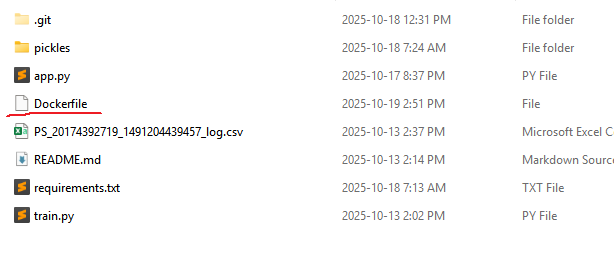

Next build an image using this command `docker image build -t docker.io/mrezvandehy/contrizing_ml_model_with_docker:v2 .` on the same directory in bash: where `-t` is tag, and `v2` is version 2:
* `mrezvandehy` is Docker Hub username.
* `contrizing_ml_model_with_docker` is the image (and also matches your GitHub repository name).
* `v2` represents version 2 of the image.

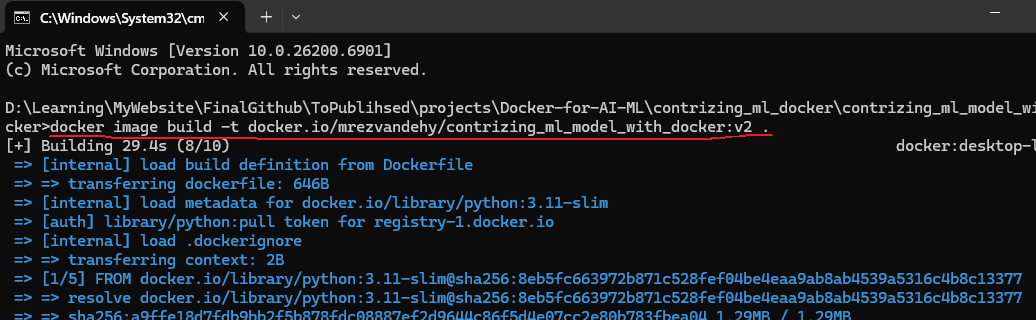

Here is running the Dockerfile:
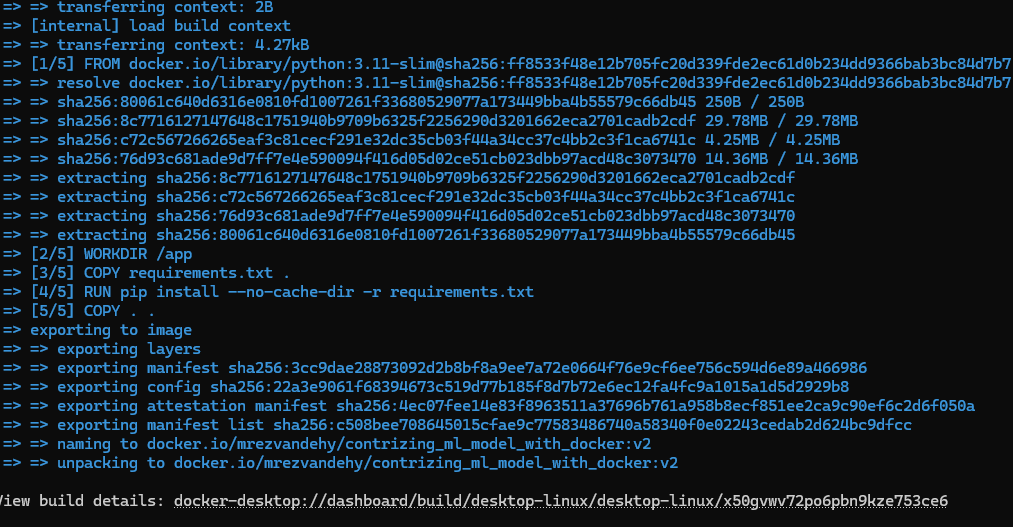

Now we can see it on Docker desktop [docker-desktop://dashboard/build/desktop-linux/desktop-linux/bsip37dnr1vuyl0ve4y9dmylc](docker-desktop://dashboard/build/desktop-linux/desktop-linux/bsip37dnr1vuyl0ve4y9dmylc):

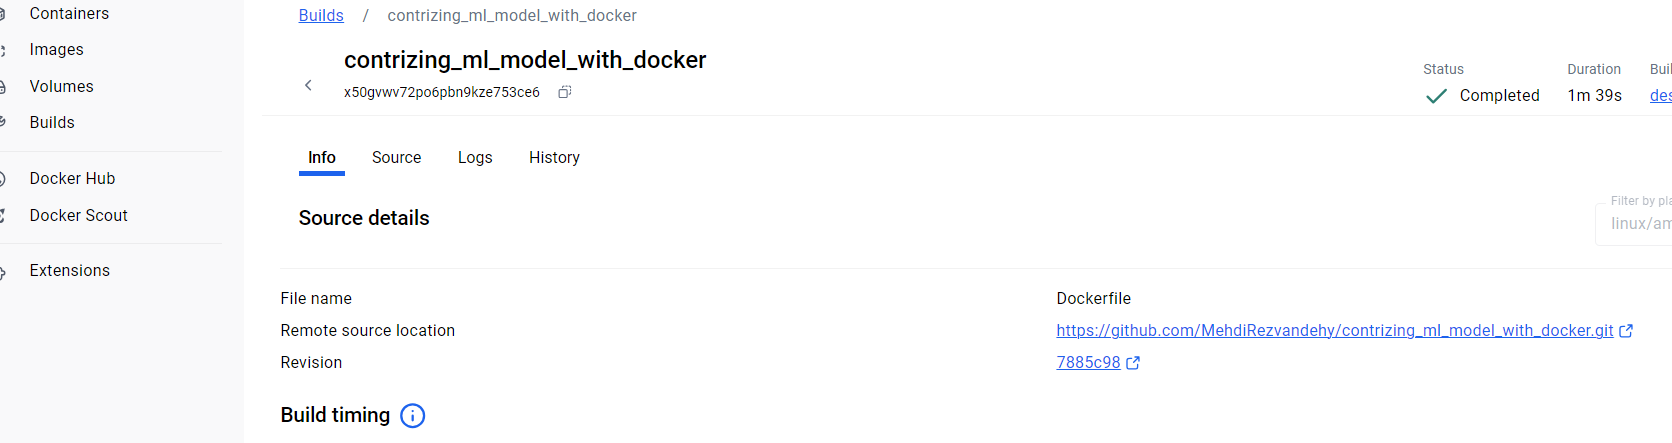

### Test Image 

Now we can launch the container out of this and see this image already works or not:

In [20]:
!docker image ls mrezvandehy/contrizing_ml_model_with_docker

REPOSITORY                                    TAG       IMAGE ID       CREATED         SIZE
mrezvandehy/contrizing_ml_model_with_docker   v2        a8c0608e41a0   2 minutes ago   2.16GB
mrezvandehy/contrizing_ml_model_with_docker   v1        8b354c628b4c   4 minutes ago   294MB


As can be seen the v2 version has been added.

Let's test the application to see if it works or not by this command `docker run -idt -p 8502:8501 mrezvandehy/contrizing_ml_model_with_docker:v2`

In [21]:
!docker run -idt -p 8502:8501 mrezvandehy/contrizing_ml_model_with_docker:v2

dee9d8f30f9cb9ab3b5d4cdfec9643904b45d28a3352fcb28d2639f3e63e4987


If you receive an error, it is bacause the container `dev_fraud_container` has not be deleted. It can be done by this command `docker rm -f dev_fraud_container`

then run again
`docker run -idt -p 8502:8501 mrezvandehy/contrizing_ml_model_with_docker:v2`

Now it should work!

In [23]:
!docker ps

CONTAINER ID   IMAGE                                            COMMAND                  CREATED              STATUS              PORTS                    NAMES
dee9d8f30f9c   mrezvandehy/contrizing_ml_model_with_docker:v2   "streamlit run app.pâ€¦"   About a minute ago   Up About a minute   0.0.0.0:8502->8501/tcp   eloquent_lamarr


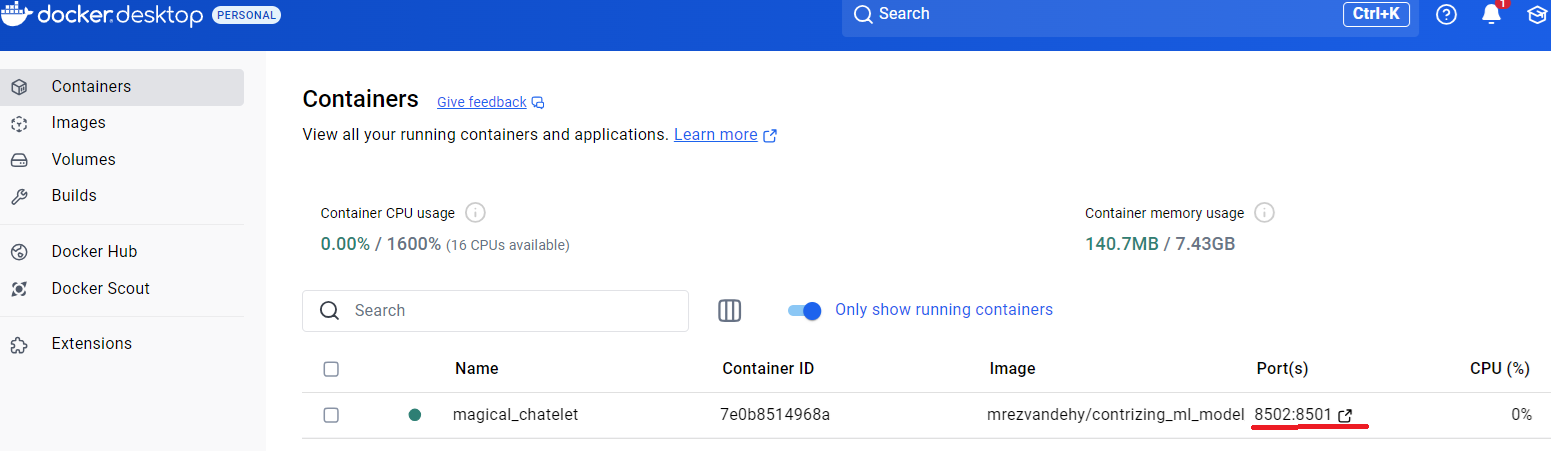

http://localhost:8502/

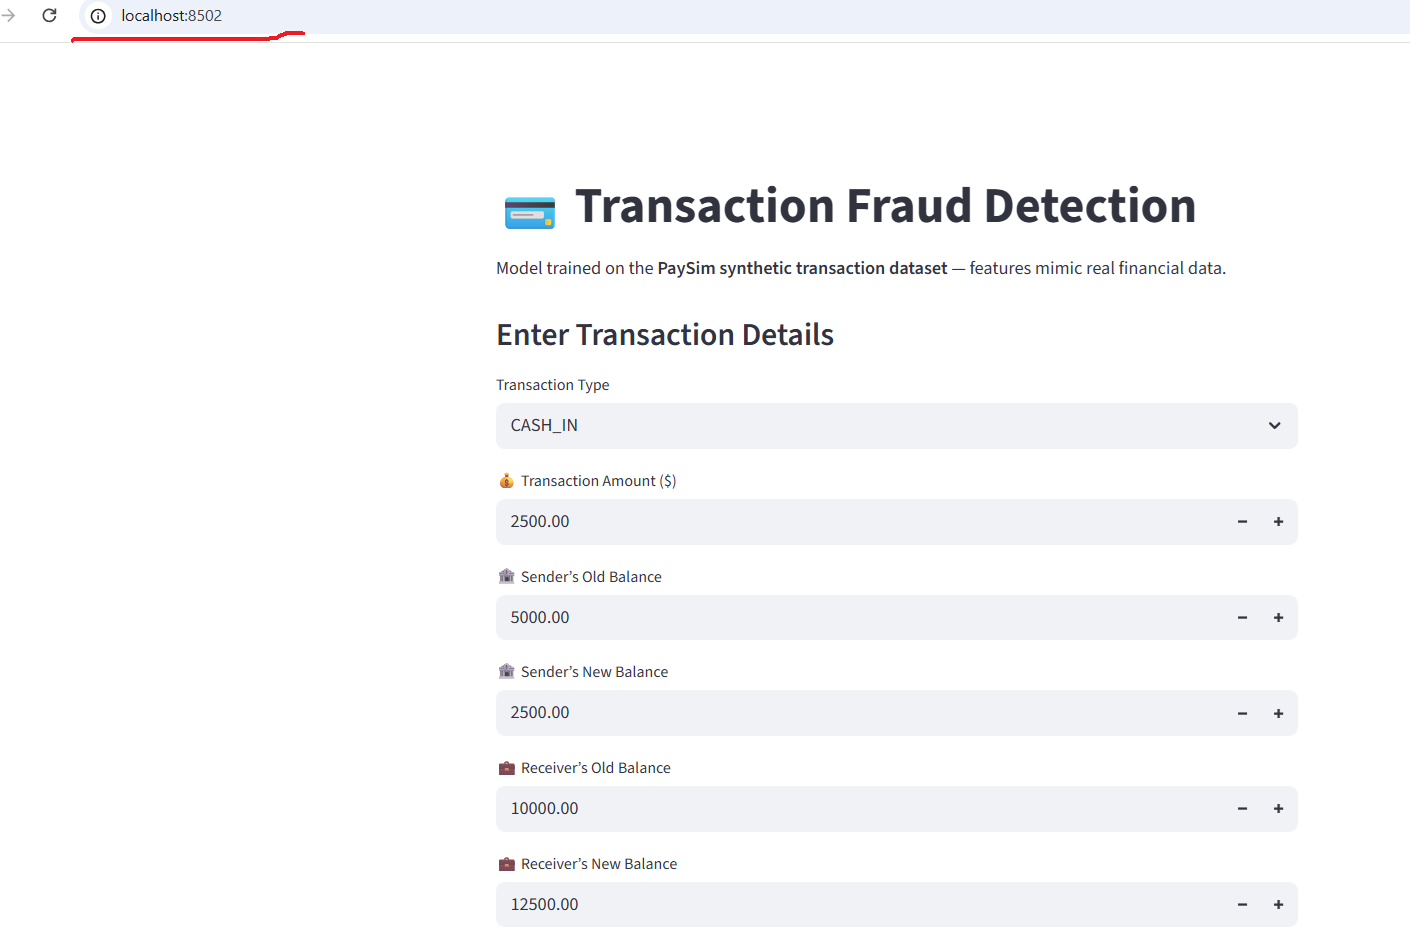

### Publish Container Image

In [24]:
!docker image ls mrezvandehy/contrizing_ml_model_with_docker

REPOSITORY                                    TAG       IMAGE ID       CREATED         SIZE
mrezvandehy/contrizing_ml_model_with_docker   v2        a8c0608e41a0   4 minutes ago   2.16GB
mrezvandehy/contrizing_ml_model_with_docker   v1        8b354c628b4c   6 minutes ago   294MB


The version 1 (v1) is the manual procedure and version 2 (v2) is using Docker File

In [25]:
!docker history mrezvandehy/contrizing_ml_model_with_docker:v1

IMAGE          CREATED         CREATED BY                                      SIZE      COMMENT
8b354c628b4c   6 minutes ago   python3                                         61MB      
dbf1de478a55   7 months ago    CMD ["python3"]                                 0B        buildkit.dockerfile.v0
<missing>      7 months ago    RUN /bin/sh -c set -eux;  for src in idle3 pâ€¦   16.4kB    buildkit.dockerfile.v0
<missing>      7 months ago    RUN /bin/sh -c set -eux;   savedAptMark="$(aâ€¦   51.7MB    buildkit.dockerfile.v0
<missing>      7 months ago    ENV PYTHON_SHA256=849da87af4df137710c1796e27â€¦   0B        buildkit.dockerfile.v0
<missing>      7 months ago    ENV PYTHON_VERSION=3.11.12                      0B        buildkit.dockerfile.v0
<missing>      7 months ago    ENV GPG_KEY=A035C8C19219BA821ECEA86B64E628F8â€¦   0B        buildkit.dockerfile.v0
<missing>      7 months ago    RUN /bin/sh -c set -eux;  apt-get update;  aâ€¦   10.4MB    buildkit.dockerfile.v0
<missing>      7 mo

In [26]:
!docker history mrezvandehy/contrizing_ml_model_with_docker:v2

IMAGE          CREATED         CREATED BY                                      SIZE      COMMENT
a8c0608e41a0   4 minutes ago   CMD ["streamlit" "run" "app.py" "--server.poâ€¦   0B        buildkit.dockerfile.v0
<missing>      4 minutes ago   ENV STREAMLIT_DISABLE_VERSION_CHECK=true STRâ€¦   0B        buildkit.dockerfile.v0
<missing>      4 minutes ago   EXPOSE map[8501/tcp:{}]                         0B        buildkit.dockerfile.v0
<missing>      4 minutes ago   COPY . . # buildkit                             60.1MB    buildkit.dockerfile.v0
<missing>      4 minutes ago   RUN /bin/sh -c pip install --no-cache-dir -râ€¦   1.28GB    buildkit.dockerfile.v0
<missing>      5 minutes ago   COPY requirements.txt . # buildkit              12.3kB    buildkit.dockerfile.v0
<missing>      5 minutes ago   WORKDIR /app                                    8.19kB    buildkit.dockerfile.v0
<missing>      2 weeks ago     CMD ["python3"]                                 0B        buildkit.dockerfile.v0
<

Using v2, we get optimized version of the image as port 8502 can be run.

In [27]:
!docker ps

CONTAINER ID   IMAGE                                            COMMAND                  CREATED         STATUS         PORTS                    NAMES
dee9d8f30f9c   mrezvandehy/contrizing_ml_model_with_docker:v2   "streamlit run app.pâ€¦"   2 minutes ago   Up 2 minutes   0.0.0.0:8502->8501/tcp   eloquent_lamarr


In [28]:
# make v2 as latest
!docker image tag mrezvandehy/contrizing_ml_model_with_docker:v2  mrezvandehy/contrizing_ml_model_with_docker:latest

In [29]:
!docker image ls mrezvandehy/contrizing_ml_model_with_docker

REPOSITORY                                    TAG       IMAGE ID       CREATED         SIZE
mrezvandehy/contrizing_ml_model_with_docker   latest    a8c0608e41a0   5 minutes ago   2.16GB
mrezvandehy/contrizing_ml_model_with_docker   v2        a8c0608e41a0   5 minutes ago   2.16GB
mrezvandehy/contrizing_ml_model_with_docker   v1        8b354c628b4c   7 minutes ago   294MB


Now how to publish this layer `!docker image push mrezvandehy/contrizing_ml_model_with_docker:latest`. First you have to log in container

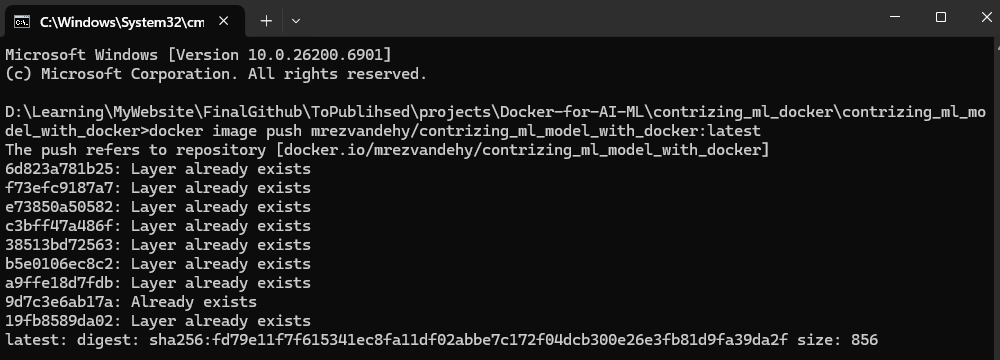

The image has been published to the registry, we can see it on registry. Go to your profile, you can see your image as below https://hub.docker.com/repository/docker/mrezvandehy/contrizing_ml_model_with_docker/tags:

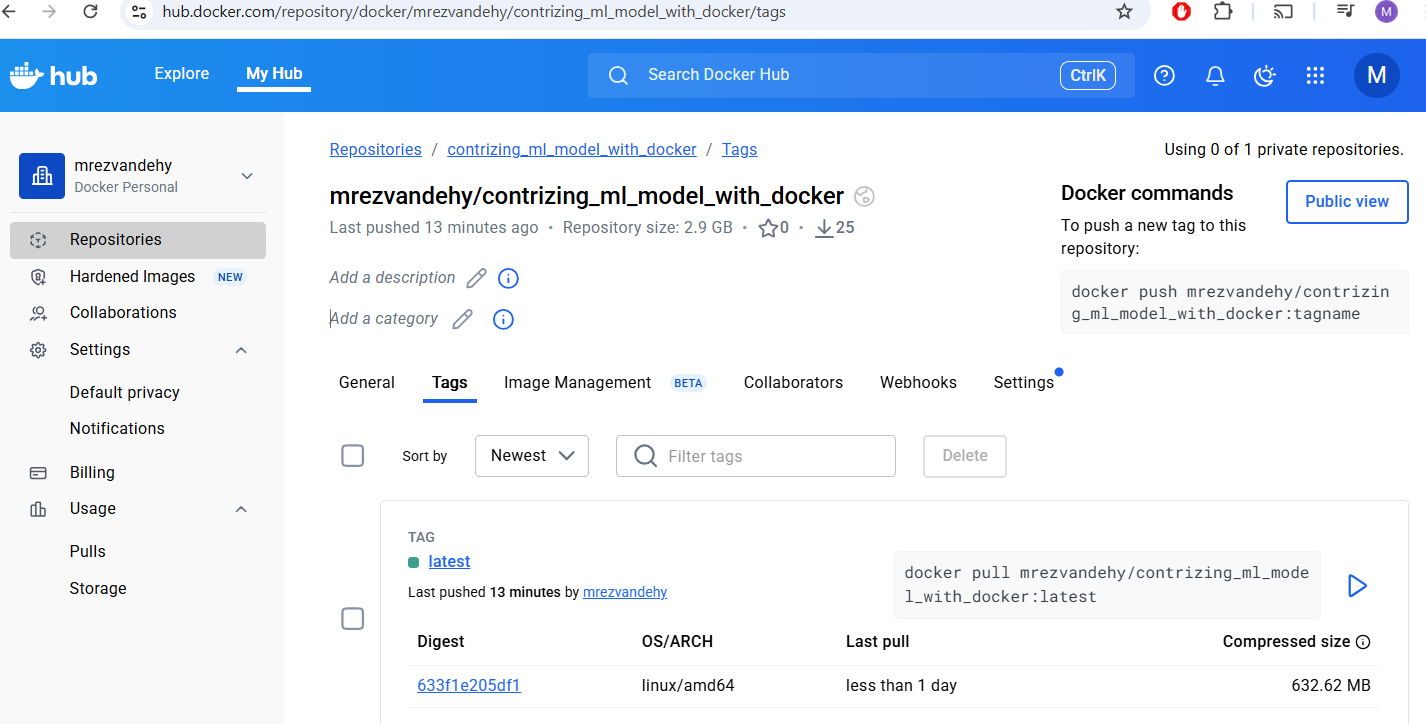

# Deploy containerized Streamlit app on Hugging Face

After getting the code and the pickle files and package it to a contrainer image. We saw that how to publish that image to registery (Docker Hub). Now finaly we want to deploy the image to some places, that is huggingface space that has free space. That is hosted enviroment that we host it for free:

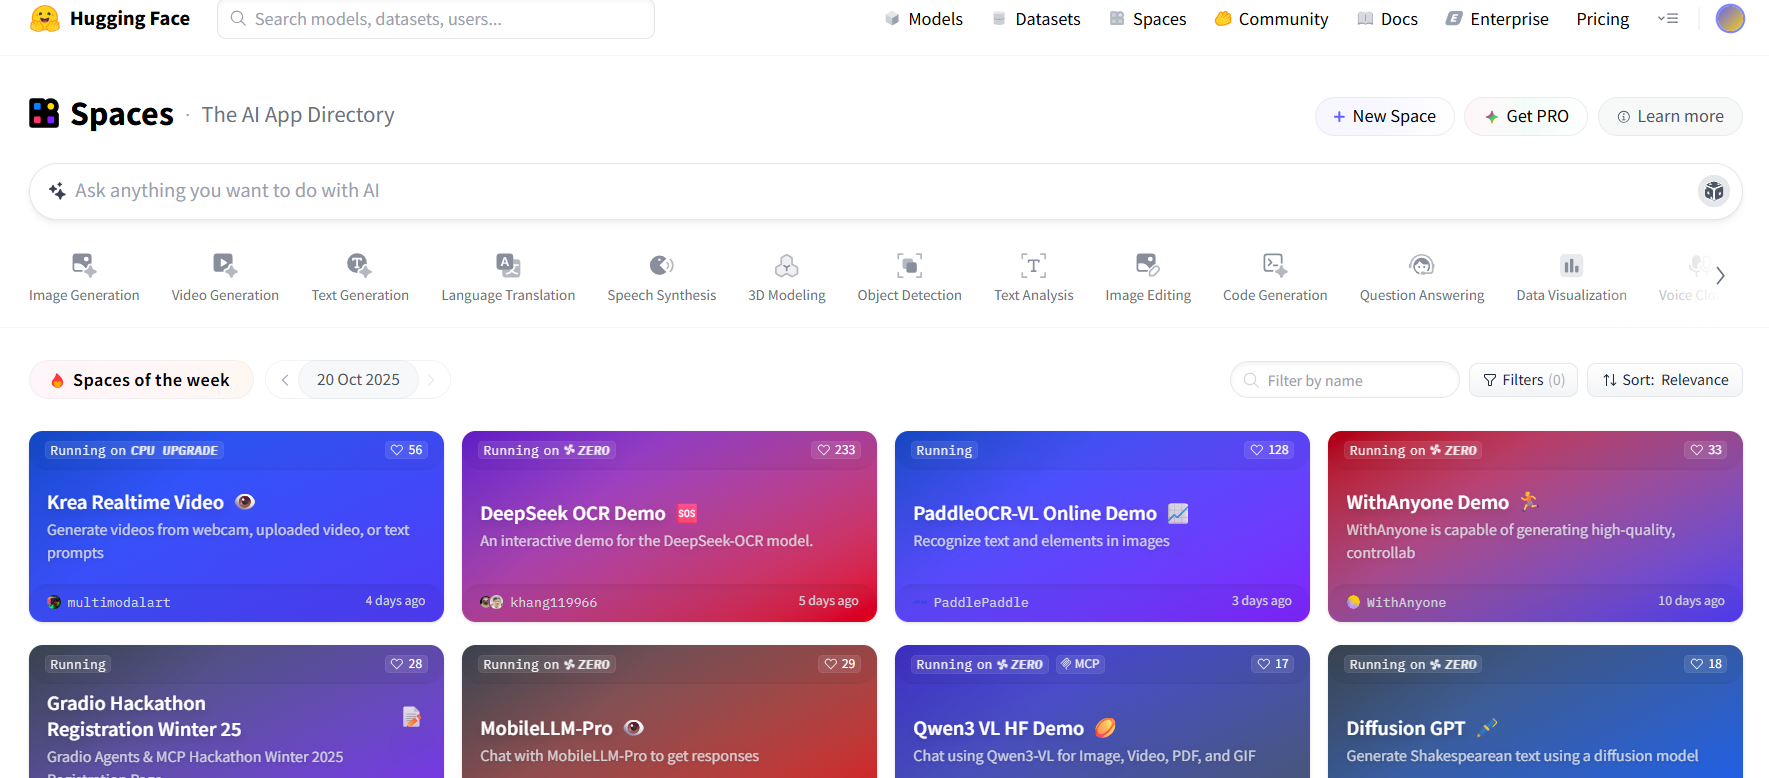

We should select the right type of space which is Docker for our case, fillout the instruction and then create the space

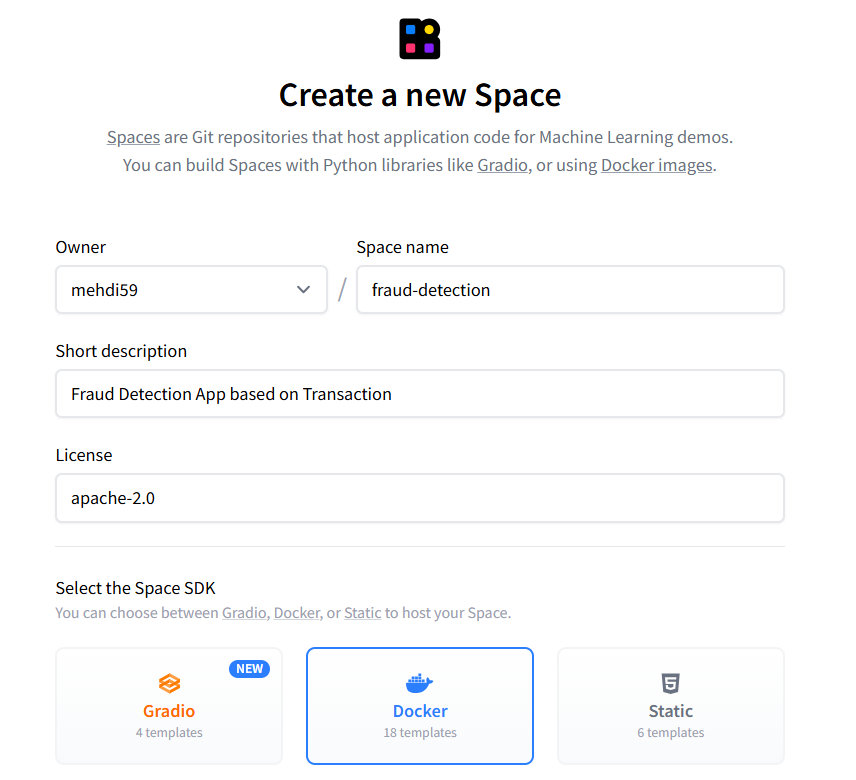

Here is created Space:

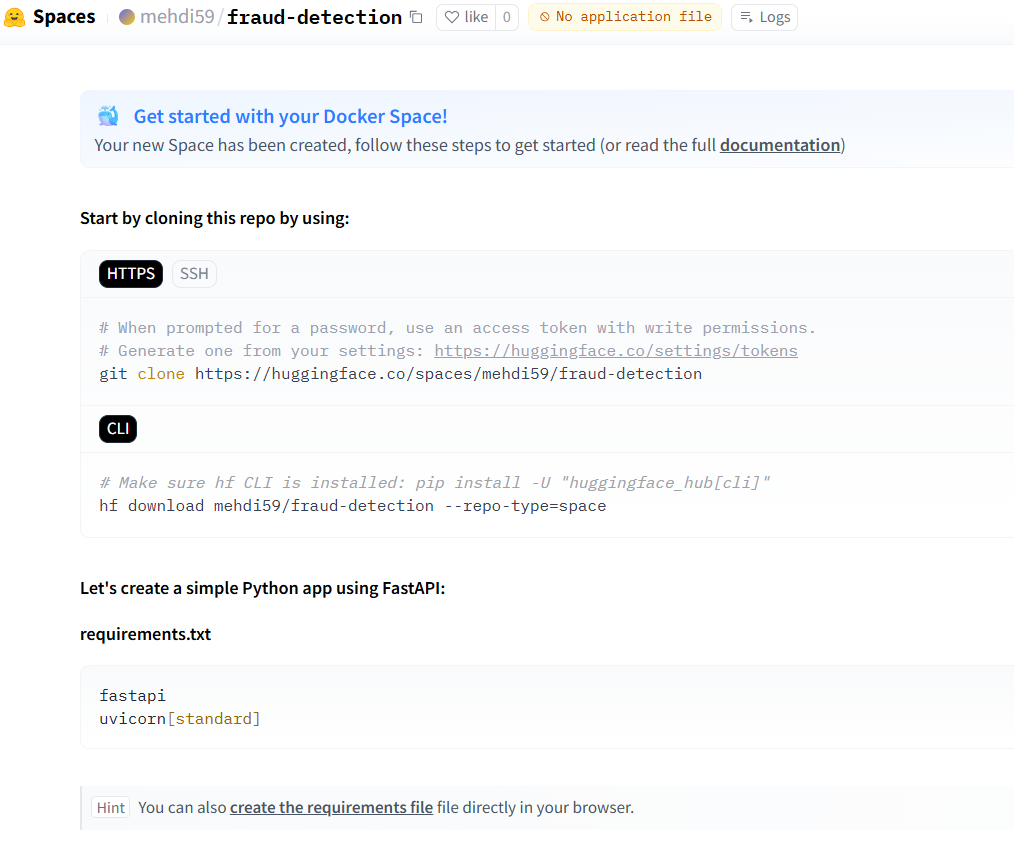

One option is to clone this space: https://huggingface.co/spaces/mehdi59/fraud-detection and add your code to it. That is one option. Another option is to upload your file directly here:

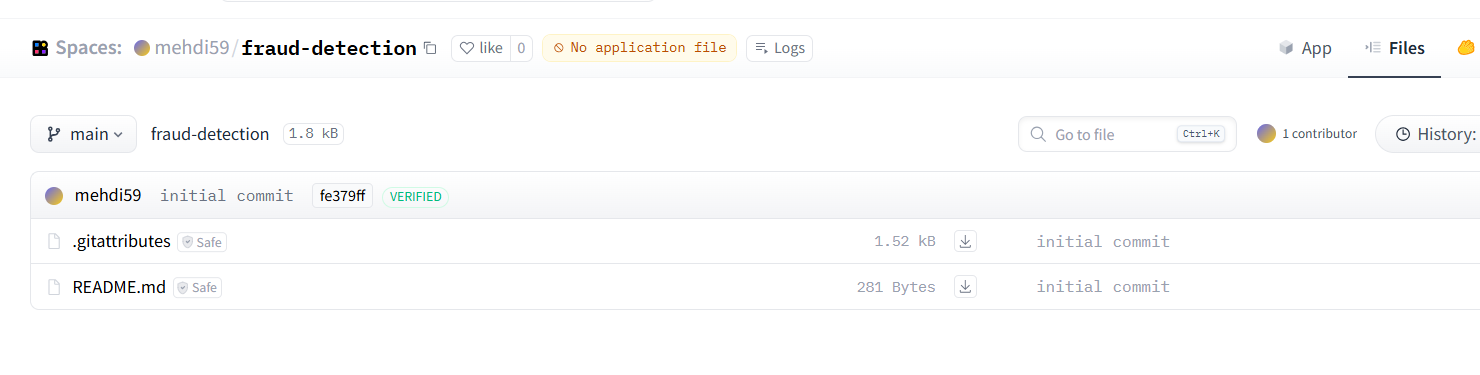

This has a `README.md`:
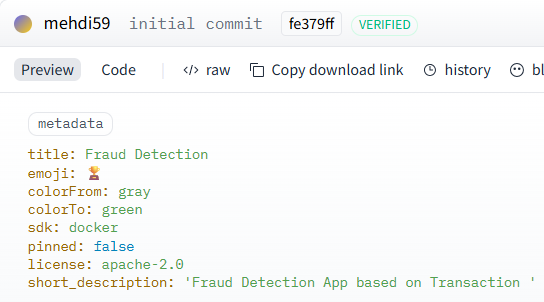

To make it simple, create this https://huggingface.co/spaces/mehdi59/fraud-detection as a remote for our repository, check in everything in repository and push it to this particular repo using `git remote add`. First we want to know what remote exits using `git remote show`. Currently, there is only `origin` which is GitHub repository:

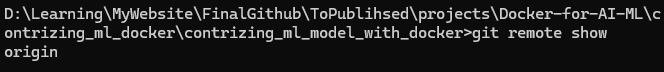

To show origin, use command `git remote show origin`:
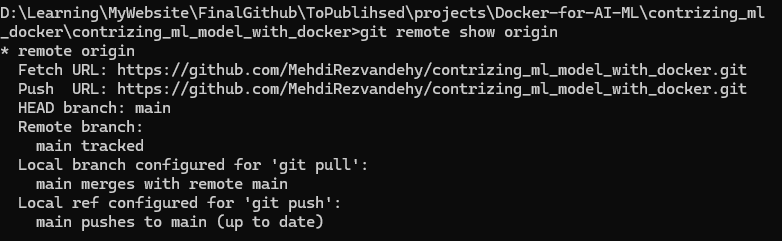

Now we can add hugging face repository as remote by `git remote add hf https://huggingface.co/spaces/mehdi59/fraud-detection` where hf is the name we assigned. Now we have two remotes one origin and another on hf:

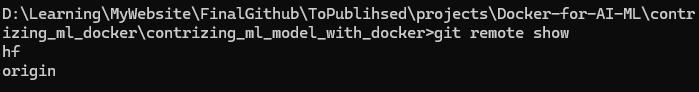
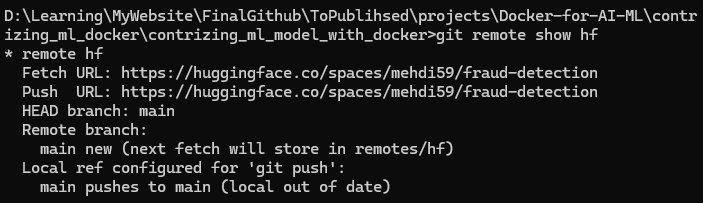

Next is to push all the code to HuggingFace by force push changes `git push hf --force`. Then the app start building on HuggingFace by creating an image from Dockerfile and publishing on its own internal registry It also starts the applition as it is included in Dockerfile:

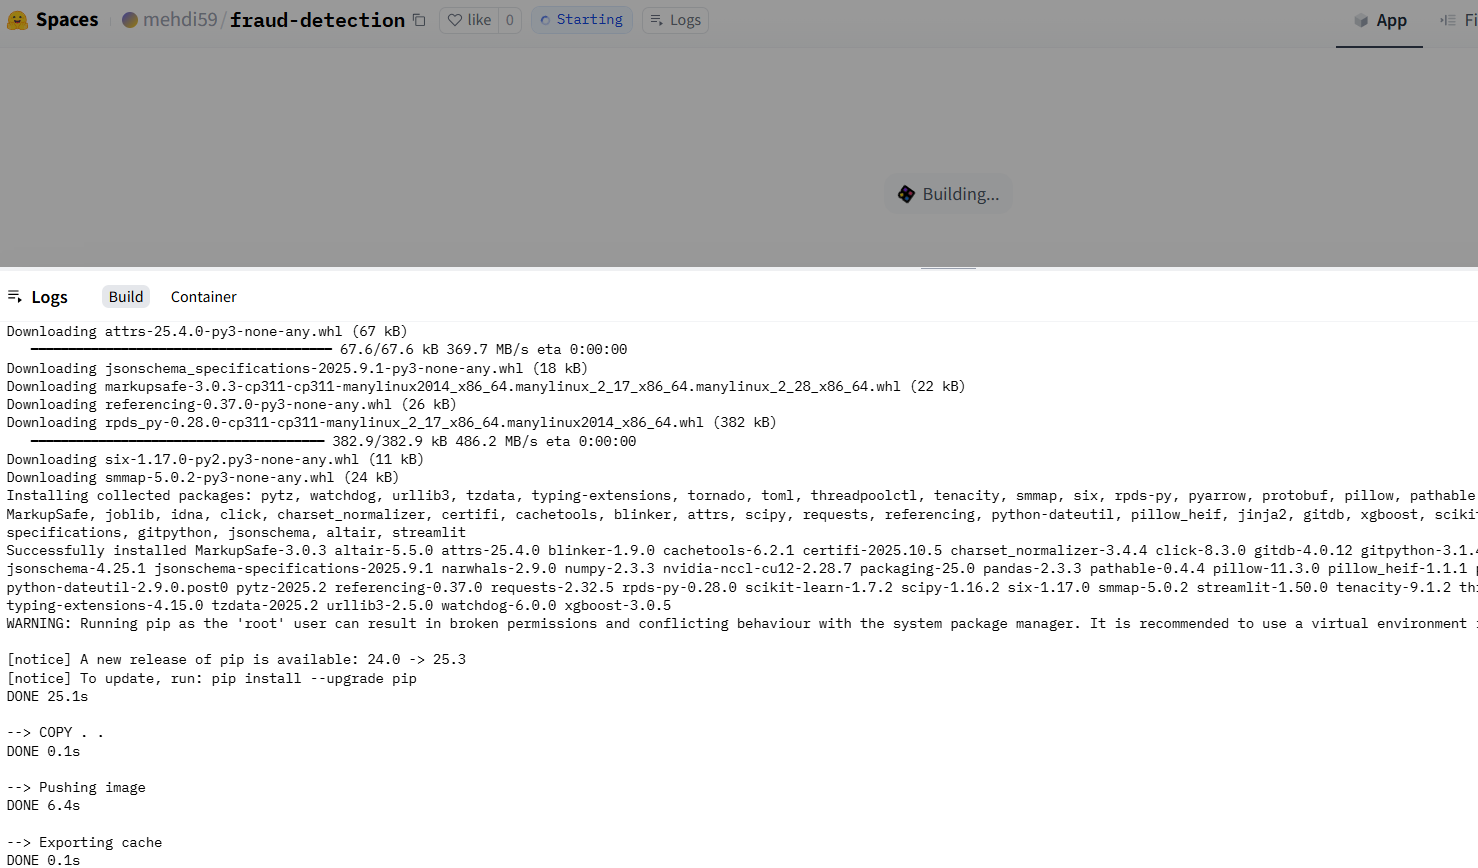

The app has been deployed on Huggingface on https://huggingface.co/spaces/mehdi59/fraud-detection:
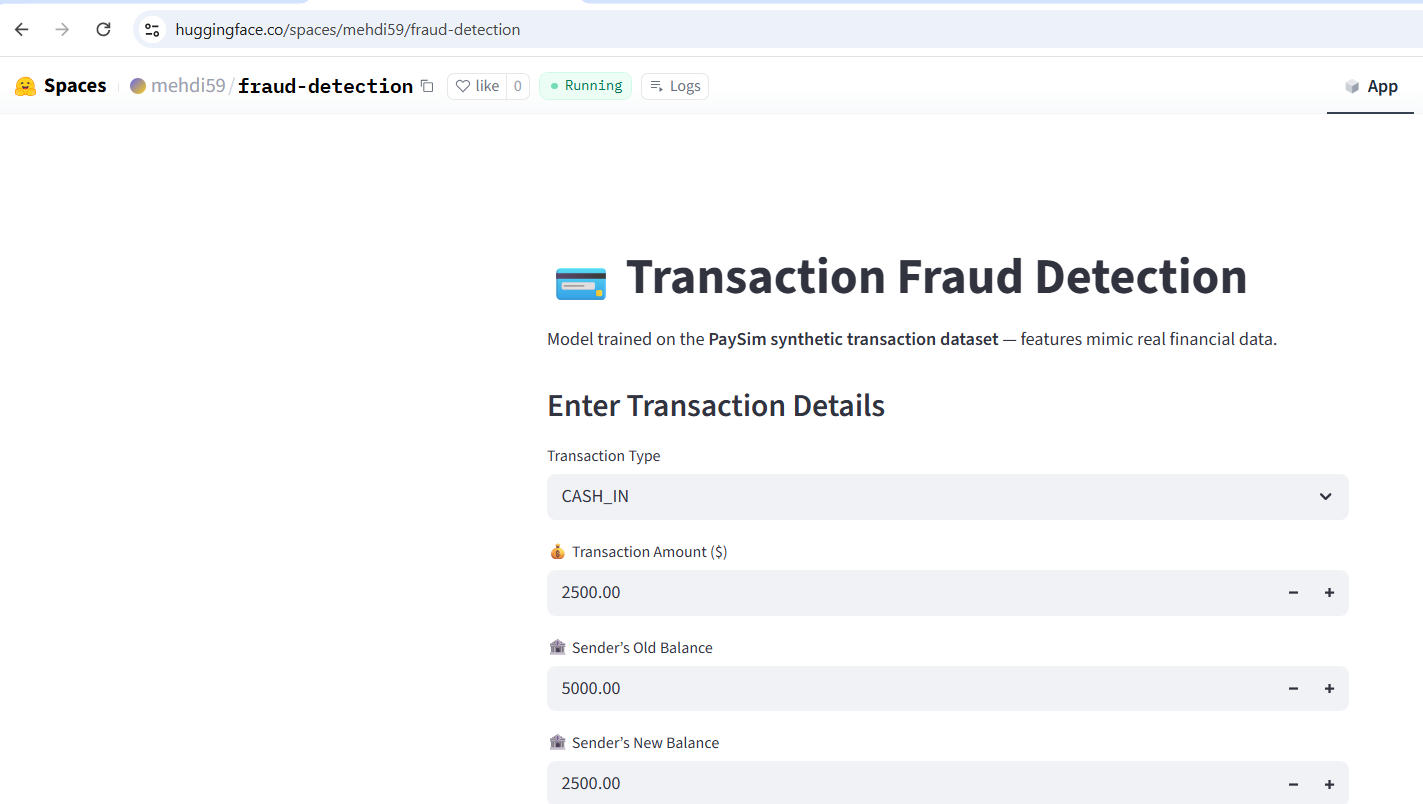    